_**Note:** This notebook is intended solely as a demonstration of how to use the developed codebase. The outputs and results presented here are for illustrative purposes only and should not be considered accurate, validated, or representative of real-world performance. The focus of this notebook is on showcasing functionality, not on the correctness or significance of the results._

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Additional code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
# import sys
# sys.path.append('../src/')  # path to root of code_base directory - Only if not installed as a package

from laneq.degradation_calculator.calculate_degradation import get_degradation_annotations_n_segment_labels 
from laneq.degradation_calculator.degradation_utils import box_coco_to_corner, add_bbox
from laneq.model_suite.utils.preprocessing import load_image, load_mask

## Inputs parameters

In [35]:
# path for image and mask
img_dir = "/cs6945share/retro_project/bdd100k/images/train/"
mask_dir = "/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/train/"

segments_output_dir = "./output/segments/"
annotations_output_dir = "./output/annotations/"

filename = "00067cfb-f1b91e3c.jpg"

# BEV output size 
bev_transform_shape = (640, 640)

# target class threshold bins
degradation_threshold_bins = [0, 0.15, 0.3, 1]

# class colors
_color_map = {0: (0, 255, 0), 1: (255, 255, 0), 2: (255, 0, 0)}

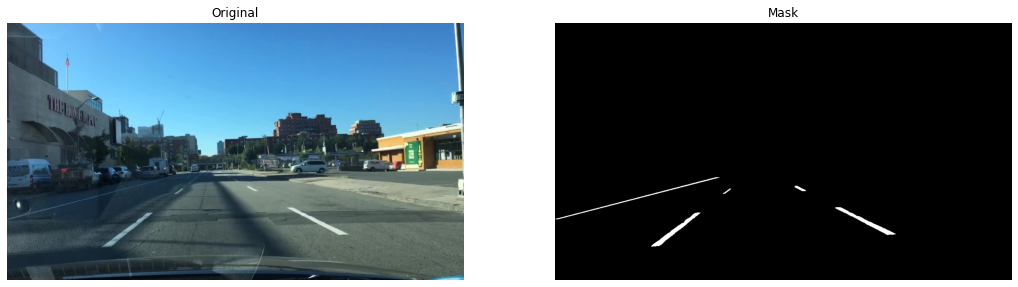

In [24]:
img_path = os.path.join(img_dir, filename)
img = load_image(img_path)

file_initials = ".".join(filename.split(".")[:-1])
mask_path = os.path.join(mask_dir, f"{file_initials}.png")
mask = load_mask(mask_path)
mask = mask.astype(np.uint8)

# visualize inputs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original")
ax[1].imshow(mask, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Mask")
plt.show()

In [30]:
# get annotation and segment labels
annotations, segment_labels = get_degradation_annotations_n_segment_labels(img=img, mask=mask,
                                                                           segment_output_dir=segments_output_dir,
                                                                           save_name=file_initials,
                                                                           bev_shape=bev_transform_shape,
                                                                           degradation_bins=degradation_threshold_bins)

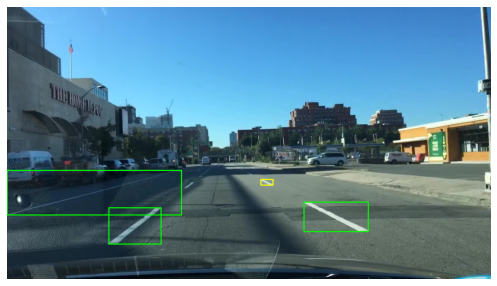

In [38]:
# visualize results
temp = img.copy()
for component in annotations:
    ratio = component["degradation"]
    bbox = component["bounding_box"]
    target = component["degradation_target"]
    if ratio < 0:
        continue
    bbox = box_coco_to_corner(bbox)
    color = _color_map[target]
    temp = add_bbox(img=temp, bbox=bbox, font_scale=0.8, bbox_color=color)

plt.figure(figsize=(15, 5))
plt.imshow(temp)
plt.axis("off")
plt.show()

## To label multiple files

In [39]:
from laneq.degradation_calculator.calculate_degradation import main_degradation_annotations_generator

In [43]:
# path for image and mask
d_type = "test"
img_dir = f"/cs6945share/retro_project/bdd100k/images/{d_type}/"
mask_dir = f"/cs6945share/retro_project/bdd100k/generated_masks_v0_3//masks_v3/{d_type}/"

segments_output_dir = "./output/segments/"
annotations_output_dir = "./output/annotations/"

bev_transform_shape = (640, 640)  # BEV output size 

# filtering hyperparameters
min_area = 100
min_transform_area = 0.6
min_segment_dimension = 4

# degradation calculation hyperparameters
component_len_limit = 100     # length of a lane above which degradatrion needs to be calculated in parts
bin_length = 80               # length of a single part
relax_threshold = 0.05        # percentage of the calculated threshold to reduce to relax the good pixel creterion 

# target class threshold bins
degradation_threshold_bins = [0, 0.1, 0.3, 1]

In [44]:
main_degradation_annotations_generator(image_dir=img_dir, mask_dir=mask_dir, segment_output_dir=segments_output_dir, annotations_output_dir=annotations_output_dir, 
                                       bev_shape=bev_transform_shape,
                                       min_area=min_area, min_roi_overlap=min_transform_area, dilated_kernel=13, min_segment_dimension=min_segment_dimension,
                                       comp_len_limit=component_len_limit, sub_comp_len=bin_length, 
                                       relax_threshold=relax_threshold, degradation_bins=degradation_threshold_bins)

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]

Degradation labelling Completed! Total time: 0.2578 min
Segment label file saved at ./output/segments/degradation_segment_labels.csv
